# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import sys
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient
import time
import DcOrientRandomSimple
import DcSimple
import StaticSimple
import BigBucketSimple
import SmallBucketSimple
import StaticRandom

# Data Generation

In [33]:
G = misc.createRandomGraph(size=200, density=0.5, variation=0.4, maxDegree=None)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 250
Edges: 20006
Density: 0.6427630522088353
Max Degree: 182
Average Degree: 160.048
Static Coloring uses 53 colors


6.38784

In [34]:
updates = misc.extractUpdates(G, 'random')

In [44]:
updates = misc.extractStream(G, 10000, 0.5, 'random')

In [35]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

In [45]:
Ge = G.copy()

# Graph Saving and Loading

In [36]:
# Always define a name
name = '200Random'

In [50]:
# Create graph data
nodes = list(Ge.nodes())
edges = list(Ge.edges())
updateEdges = list(update[0] for update in updates)
updateTypes = list(update[1] for update in updates)

ge = Ge.copy()
oldColoring = nx.coloring.greedy_color(ge)
newColoring = dict({})
staticColors = []
staticRecolors = []
for update in updates:
    if update[1]:
        ge.add_edge(update[0][0], update[0][1])
    else:
        ge.remove_edge(update[0][0], update[0][1])
    newColoring = nx.coloring.greedy_color(ge)
    staticColors.append(misc.numberOfColors(newColoring))
    staticRecolors.append(misc.numberOfRecolors(oldColoring, newColoring))
    oldColoring = newColoring

gd = misc.GraphData(name, nodes, edges, updateEdges, updateTypes, staticColors, staticRecolors)
totStaticColors = gd.colorSum
totStaticRecolors = gd.recolorSum

In [ ]:
# Save graph data
misc.saveGraphData(gd)

In [21]:
# Load graph data
gd = misc.loadGraphData(name)

Ge = gd.G.copy()

updates = gd.updates
staticColors = gd.staticColors
staticRecolors = gd.staticRecolors
totStaticColors = gd.colorSum
totStaticRecolors = gd.recolorSum

# Algorithm Preparation

In [5]:
class Exp:
    def __init__(self, G, updates, experimentList, name):
        self.G = G
        self.updates = updates
        self.experimentList = experimentList
        self.name = name

In [57]:
# Only run once
experiments = []

In [58]:
experimentList = []

experimentList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
# experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])

d = 5
experimentList.append([SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10])

d = 5
experimentList.append([BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10])

l = 10
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

l = 100
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

experimentList.append([DcOrient.DcOrientAlgo(Ge), 'DC-Orient'])

l = 10
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l), 'Static-Simple algorithm (l = ' +str(l)+ ')'])

l = 100
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l), 'Static-Simple algorithm (l = ' +str(l)+ ')'])

p = 0.8
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Simple (p = '+ str(p) + ')'])

p = 0.998
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Simple (p = '+ str(p) + ')'])

In [12]:
experimentList = []
p = 0.0
experimentList.append([DcOrientRandomSimple.DcOrientRandomSimpleAlgo(Ge, p), 'DC-Orient without optimizations'])
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Orient with optimizations'])

In [59]:
experiments.append(Exp(G, updates, experimentList, name))

In [60]:
for exp in experiments:
    print(exp.name)

200Random


# Experimenting

In [61]:
def runExperiments(experiments):

    for exp in experiments:
        
        G = exp.G
        updates = exp.updates
        experimentList = exp.experimentList
        name = exp.name

        # CSV Writer
        f = open('experiments/'+ str(name) + '.csv', 'w', newline='')
        writer = csv.writer(f)

        print('Graph used in the experiment:')
        misc.graphInfo(G)

        row = [str(G.number_of_nodes()) + ' Nodes; ' + str(G.number_of_edges()) + ' Edges; C = ' + str(round(float(totStaticColors)/len(updates), 2)),'Average nr. of Recolors', 'Average nr. of Colors', 'Time Taken (s)']
        writer.writerow(row)

        for experiment in experimentList:

            row = [str(experiment[1])]

            if len(experiment) == 3:
                random.seed(experiment[2])
            else:
                random.seed()

            print("")
            print("------------------------------------------------------------------")
            print(str(experiment[1]) + ":")
            iterator = misc.UpdateIterator(experiment[0], updates)

            recolors = 0
            colors = 0
            
            timer = time.perf_counter()

            while True:
                if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
                    raise ValueError('The coloring produced is incorrect')
                c1 = iterator.algo.getColoring()
                if iterator.runUpdate(1):
                    c2 = iterator.algo.getColoring()
                    recolors += misc.numberOfRecolors(c1, c2)
                    colors += misc.numberOfColors(c2)
                else:
                    #print("all updates finished")
                    break

            timer = time.perf_counter() - timer

            print("")

            # Average values
            # avgRecolors = float(recolors)/len(updates)
            # print("Average number of recolors per update: " + str(avgRecolors))
            # row.append(str(round(avgRecolors, 2)))
            # avgColors = float(colors/len(updates))
            # print("Average number of colors used: " + str(avgColors))
            # row.append(str(round(avgColors, 2)))

            # Ratios
            recolorRatio = float(recolors)/totStaticRecolors
            print("Ratio of recolors: " + str(recolorRatio))
            row.append(str(round(recolorRatio, 2)))
            colorRatio = float(colors)/totStaticColors
            print("Ratio of colors used: " + str(colorRatio))
            row.append(str(round(colorRatio, 2)))

            print("Time taken : " + str(timer) + " seconds")
            row.append(str(round(timer, 3)))
            # print("Average elementary operations : " + str(iterator.avgElemCounter))
            print("------------------------------------------------------------------")
            writer.writerow(row)

        print("End of experiment list reached")
        f.close()


In [62]:
runExperiments(experiments)

Graph used in the experiment:
Nodes: 250
Edges: 20006
Density: 0.6427630522088353
Max Degree: 182
Average Degree: 160.048
Static Coloring uses 53 colors

------------------------------------------------------------------
Random Warm-Up:


ZeroDivisionError: float division by zero

In [51]:
nx.info(experiments[0].experimentList[0][0].G)

'Graph with 215 nodes and 12933 edges'

In [52]:
misc.numberOfColors(nx.coloring.greedy_color(experiments[0].experimentList[0][0].G))

39

# Graph Generation Experiments

In [19]:
e = [['SmallBucket', 1, 30],
    ['BigBucket', 1, 30],
    ['StaticDynamic', 1, 200],
    ['StaticSimple', 1, 200],
    ['DcSimple', 0.4, 1],
    ['StaticRandom', 0.4, 1]]

iterations = 3

In [29]:
e = [['BigBucket', 1, 30],
    ['BigBucketSimple', 0, 1, 2],
    ['BigBucketSimple', 0, 1, 5],
    ['BigBucketSimple', 0, 1, 10],
    ['BigBucketSimple', 0, 1, 20],
    ['BigBucketSimple', 0, 1, 30]]

iterations = 3

In [30]:
coordinateLists = []
experimentListList = []

# Add a single iteration for the random warm ups
experimentList = []
tempList = []
for j in range(0, iterations):
    tempList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
experimentList.append(tempList)
experimentListList.append(experimentList)

# experimentList = []
# experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])
# experimentListList.append(experimentList)

for exp in e:
    # Add different algorithms one by one by changing parameters
    experimentList = []
    algo = exp[0]
    min = exp[1]
    max = exp[2]
    r = 100             # Number of experiments per algorithm
    current = min
    lastCurrent = -100
    for i in range(0, r):
        if algo == 'SmallBucket':
            d = int(current)
            if d != int(lastCurrent):
                experimentList.append([[SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10]])
        elif algo == 'BigBucket':
            d = int(current)
            if d != int(lastCurrent):
                experimentList.append([[BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10]])
        elif algo == 'BigBucketSimple':
            d = exp[3] #temporary
            p = current
            experimentList.append([[BigBucketSimple.BigBucketSimpleAlgo(d, p, Ge), 'Big-Bucket Simple algorithm (p = '+str(p)+')']])
        elif algo == 'SmallBucketSimple':
            d = 10
            p = current
            experimentList.append([[SmallBucketSimple.SmallBucketSimpleAlgo(d, p, Ge), 'Small-Bucket Simple algorithm (p = '+str(p)+')']])
        elif algo == 'StaticDynamic':
            l = int(current)
            if l != int(lastCurrent):
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])
                experimentList.append(tempList)
        elif algo == 'StaticSimple':
            l = int(current)
            if l != int(lastCurrent):
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticSimple.StaticSimpleAlgo(Ge, l=l), 'Static-Simple (l = '+str(l)+')'])
                experimentList.append(tempList)
        elif algo == 'DcSimple':
            p = current
            tempList = []
            for j in range(0, iterations):
                tempList.append([DcSimple.DcSimpleAlgo(Ge, p=p), 'DC-Simple (p = '+str(p)+')'])
            experimentList.append(tempList)
        elif algo == 'StaticRandom':
            p = current
            tempList = []
            for j in range(0, iterations):
                tempList.append([StaticRandom.StaticRandomAlgo(Ge, p=p), 'Static Random (p = '+str(p)+')'])
            experimentList.append(tempList)

        lastCurrent = current
        current = current + ((max-min)/100)

    experimentListList.append(experimentList)

# Append a single iteration of DC-Orient
experimentList = []
experimentList.append([[DcOrient.DcOrientAlgo(Ge), 'DC-Orient', 10]])
experimentListList.append(experimentList)

In [31]:
# Print first experiment for each added algorithm
for experiments in experimentListList:
    print(experiments[0][0][1])

Random Warm-Up
Big-Bucket algorithm (d = 1)
Big-Bucket Simple algorithm (p = 0)
Big-Bucket Simple algorithm (p = 0)
Big-Bucket Simple algorithm (p = 0)
Big-Bucket Simple algorithm (p = 0)
Big-Bucket Simple algorithm (p = 0)
DC-Orient


In [32]:
for currentExperimentList in experimentListList:
    loadingBar = False

    print('Graph used in the experiment:')
    misc.graphInfo(G)

    coords = []

    for experiments in currentExperimentList:

        iters = len(experiments)
        recolors = 0
        totColors = 0
        totTime = 0
        i = 0

        for experiment in experiments:


            if len(experiment) == 3:
                random.seed(experiment[2])
            else:
                random.seed()

            print("")
            print("------------------------------------------------------------------")
            print(str(experiment[1]) + ":")
            iterator = misc.UpdateIterator(experiment[0], updates)

            
            i += 1
            print("Iteration " + str(i))
            timer = time.perf_counter()
            totalUpdates = len(updates)
            done = 0
            barLength = 64

            if loadingBar:
                #line to be overwritten
                print("")

            while True:
                
                if loadingBar:
                    #overwrite previously printed line
                    percentageDone = int(done/totalUpdates*barLength)
                    b = ("[" + percentageDone * "+" + (barLength - percentageDone) * "-" + "]")
                    sys.stdout.write('\r'+b)
                    sys.stdout.flush()

                if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
                    raise ValueError('The coloring produced is incorrect')
                c1 = iterator.algo.getColoring()
                if iterator.runUpdate(1):
                    c2 = iterator.algo.getColoring()
                    recolors += misc.numberOfRecolors(c1, c2)
                    done += 1
                else:
                    #print("all updates finished")
                    break

            timer = time.perf_counter() - timer
            totTime += timer

            if loadingBar:
                #overwrite previously printed line
                b = ("")
                sys.stdout.write('\r'+b)
                sys.stdout.flush()

            avgColors = float(recolors)/(len(updates))
            b = "Average number of recolors per update: " + str(avgColors)
            b = b + (barLength + 2 - len(b)) * " "
            print(b)
            totColors += misc.numberOfColors(iterator.algo.getColoring())
            print("Total number of colors used at the end: " + str(totColors))
            print("Time taken : " + str(timer) + " seconds")
            #print("Average elementary operations : " + str(iterator.avgElemCounter))
            print("------------------------------------------------------------------")
        coords.append([avgColors/iters, totColors/iters, totTime/iters])

    print("End of experiment list reached")
    coordinateLists.append(coords)


Graph used in the experiment:
Nodes: 101
Edges: 1690
Density: 0.3346534653465347
Max Degree: 45
Average Degree: 33.46534653465346
Static Coloring uses 14 colors

------------------------------------------------------------------
Random Warm-Up:
Iteration 1
Average number of recolors per update: 0.1301775147928994         
Total number of colors used at the end: 31
Time taken : 0.7939289999999346 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up:
Iteration 2
Average number of recolors per update: 0.26272189349112424        
Total number of colors used at the end: 62
Time taken : 0.734818500000074 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up:
Iteration 3
Average number of recolors per update: 0.39171597633136096        
Total number of colors used at the end: 95
Time tak

In [33]:
coordinateLists

[[[0.13057199211045364, 31.666666666666668, 0.7790496333333673]],
 [[10.053254437869823, 14.0, 1.270386900000176],
  [5.995266272189349, 15.0, 0.9631010000002789],
  [4.92603550295858, 20.0, 0.9069862000001194],
  [4.109467455621302, 23.0, 1.0335197000003973],
  [3.9928994082840235, 30.0, 0.9700778999999784],
  [3.978698224852071, 30.0, 1.1655023999996956],
  [4.150887573964497, 18.0, 0.9662782999998853],
  [3.9526627218934913, 18.0, 0.9839136999999027],
  [3.944970414201183, 18.0, 1.0999080000001413],
  [3.944970414201183, 18.0, 1.1169466999999713],
  [3.944970414201183, 18.0, 1.151338200000282],
  [3.944970414201183, 18.0, 1.1866144000000531],
  [3.944970414201183, 18.0, 1.144528199999968],
  [3.944970414201183, 18.0, 1.1214571999998952],
  [3.944970414201183, 18.0, 1.1161299999998846],
  [3.944970414201183, 18.0, 1.0970812999998998],
  [3.944970414201183, 18.0, 1.1410022000000026],
  [3.944970414201183, 18.0, 1.1401558000002296],
  [3.944970414201183, 18.0, 1.1934348999998292],
  [3

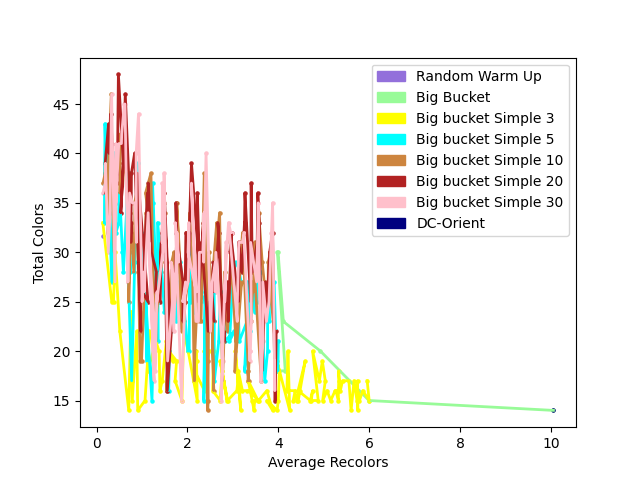

In [34]:
plt.close()

algoNames = ['Random Warm Up', 'Small Bucket', 'Big Bucket', 'Static Dynamic', 'Static Simple', 'DC-Simple', 'DC-Orient', 'Static Random']
algoNames = ['Random Warm Up', 'Big Bucket', 'Big bucket Simple 3', 'Big bucket Simple 5', 'Big bucket Simple 10', 'Big bucket Simple 20', 'Big bucket Simple 30', 'DC-Orient'] #temp
colorDict = matplotlib.colors.CSS4_COLORS
colors = [colorDict.get('mediumpurple'), colorDict.get('palegreen'), colorDict.get('yellow'), colorDict.get('cyan'), colorDict.get('peru'), colorDict.get('firebrick'), colorDict.get('pink'), colorDict.get('navy')]
patches = []


j = 0
for list in coordinateLists:
    color = colors[j]
    patch = matplotlib.patches.Patch(color=color, label=algoNames[j])
    patches.append(patch)
    
    xcoords = [i[0] for i in list]
    ycoords = [i[1] for i in list]

    # Original line plot
    plt.plot(xcoords, ycoords, c=color, linewidth=2)

    # Points plot
    plt.scatter(xcoords, ycoords, c=color, s=5)

    j += 1
plt.xlabel("Average Recolors")
plt.ylabel("Total Colors")
plt.legend(handles=patches)
plt.show()

[(1, 2), (2, 3)]


(1 2)
(1 3)
(1 2)
(2 3)


[0, 1]

# Results

In [74]:
runExperiments(experiments)

Graph used in the experiment:
Nodes: 119
Edges: 4531
Density: 0.6453496652898447
Max Degree: 91
Average Degree: 76.15126050420169
Static Coloring uses 30 colors

------------------------------------------------------------------
Small-Bucket algorithm (d = 1):

Average number of recolors per update: 0.286470977709115
Total number of colors used at the end: 119
Time taken : 5.674505700000736 seconds
Average elementary operations : 1.1302140807768704
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 3):

Average number of recolors per update: 3.1505186493047894
Total number of colors used at the end: 56
Time taken : 4.820692299999791 seconds
Average elementary operations : 3.221584639152505
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 5):

Average number of rec

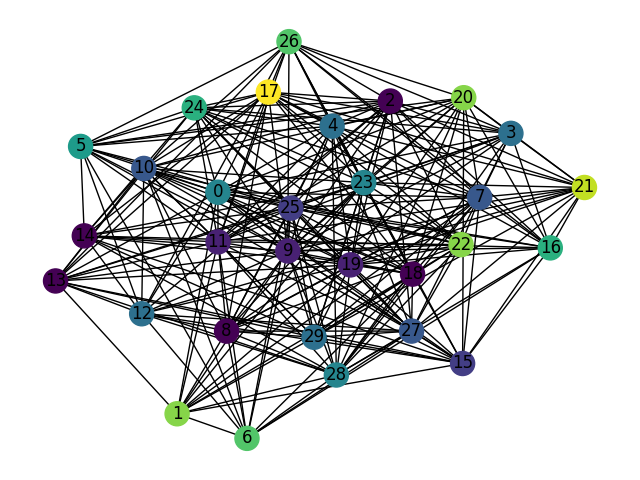

True
